In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Reshape, TimeDistributed

from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import pandas as pd
import tensorflow as tf

def make_scheduler(coeff: float, mode: str = 'linear', step=10):
    """Creates a learning rate scheduler."""
    if mode == 'linear':
        def scheduler(epoch: int, lr: float) -> float:
            return lr if epoch < step else max(lr * coeff, 1e-7)
        return scheduler
    elif mode == 'decay':
        def scheduler(epoch: int, lr: float) -> float:
            return lr * (1 + coeff * epoch) / (1 + coeff * (epoch + 1))
        return scheduler
    else:
        raise ValueError(f"Unsupported mode: {mode}. Only 'linear' and 'decay' are supported.")

In [2]:
# Load the boundary dataset
boundary_file_training = './data/reaction_diffusion_boundary_training.h5'
boundary_file_testing = './data/reaction_diffusion_boundary_testing.h5'
pod_modes_file = './data/pod_basis.h5'

with h5py.File(boundary_file_training, 'r') as h5file:
    u_boundary_train = h5file['u_boundary'][:]  # Shape: (num_samples, time_steps, boundary_features)


with h5py.File(boundary_file_testing, 'r') as h5file:
    u_boundary_test = h5file['u_boundary'][:]  # Shape: (num_samples, time_steps, boundary_features)

with h5py.File(pod_modes_file, 'r') as h5file:
    POD_modes = h5file['POD_modes'][:, :11]  # First 11 modes
    Sigma = h5file['singular_values'][:11]
    
# Load the HDF5 dataset
filename = './data/reaction_diffusion_training.h5'
with h5py.File(filename, 'r') as h5file:
    u_data = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data.shape[0]} samples.")

# Load the HDF5 dataset
filename = './data/reaction_diffusion_testing.h5'

with h5py.File(filename, 'r') as h5file:
    u_data_test      = h5file['u'][:]  # Shape: (num_samples, len(t), n, n)

print(f"Loaded dataset with {u_data_test.shape[0]} samples.")

training_data = pd.read_csv('./data/pod_coefficients_training_dataset.csv')  # Only inputs
testing_data = pd.read_csv('./data/pod_coefficients_testing_dataset.csv')  # Only inputs

Loaded dataset with 50 samples.
Loaded dataset with 50 samples.


In [3]:
# Compute POD coefficients for each time step
num_samples, time_steps, n, _ = u_data.shape
snapshots = u_data.reshape(num_samples * time_steps, n * n).T  # Flatten spatial grid
pod_coefficients = (POD_modes.T @ snapshots) / Sigma[:, None]  # Shape: (11, num_samples * time_steps)
pod_coefficients = pod_coefficients.T.reshape(num_samples, time_steps, 11)  # Reshape to match (samples, time_steps, modes)

snapshots_test = u_data_test.reshape(num_samples * time_steps, n * n).T  # Flatten spatial grid
pod_coefficients_test = (POD_modes.T @ snapshots_test) / Sigma[:, None]  # Shape: (11, num_samples * time_steps)
pod_coefficients_test = pod_coefficients_test.T.reshape(num_samples, time_steps, 11)  # Reshape to match (samples, time_steps, modes)

# Combine inputs with computed targets
X_train_nn = training_data[['d1', 'beta', 'time']].values
X_test_nn = testing_data[['d1', 'beta', 'time']].values
training_data=training_data.values.reshape((num_samples,time_steps,3))
testing_data=testing_data.values.reshape((num_samples,time_steps,3))

# Combine boundary data for LSTM input
X_train = np.concatenate([u_boundary_train, training_data], axis=-1)  # Shape: (num_samples, time_steps, boundary_features * 2)
X_test = np.concatenate([u_boundary_test, testing_data], axis=-1)  # Shape: (num_samples, time_steps, boundary_features * 2)

y_train = pod_coefficients
y_test = pod_coefficients_test

print(u_boundary_train.shape)
print(training_data.shape)
print(X_train_nn.shape)


(50, 1601, 32)
(50, 1601, 3)
(80050, 3)


In [4]:
# Standardize the inputs and outputs
input_scaler = StandardScaler()
output_scaler = StandardScaler()

# Flatten and scale boundary data
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = input_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = input_scaler.transform(X_test_flat).reshape(X_test.shape)

# Flatten and scale POD coefficients
y_train_flat = y_train.reshape(-1, y_train.shape[-1])
y_test_flat = y_test.reshape(-1, y_test.shape[-1])

y_train_scaled = output_scaler.fit_transform(y_train_flat).reshape(y_train.shape)
y_test_scaled = output_scaler.transform(y_test_flat).reshape(y_test.shape)

In [5]:
first_level_model = load_model('pod_nn_model.keras')

new_model = Sequential([
    layer.__class__.from_config(layer.get_config()) for layer in first_level_model.layers[:6]
])

# Initialize and copy weights from the original model
new_model(np.random.rand(1, 3))  # Dummy input to initialize
for i, layer in enumerate(new_model.layers):
    layer.set_weights(first_level_model.layers[i].get_weights())
    layer.trainable = False  # Make the weights non-trainable

# Verify the structure and trainable status
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 128)               │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 128)               │        16,512 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,072 (324.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 83,072 (324.50 KB)

In [6]:
num_nn_features = X_train_nn.shape[1]
num_lstm_features = X_train_scaled.shape[2]
frozen_input_shape = (X_train_nn.shape[1],)
lstm_input_shape = (time_steps, num_lstm_features)

In [7]:
# Modify the TimeDistributed call to process only the required layers
from tensorflow.keras.layers import Layer

class TimeDistributedFrozen(Layer):
    def __init__(self, frozen_model, **kwargs):
        super().__init__(**kwargs)
        self.frozen_model = frozen_model
        self.frozen_model.trainable = False  # Ensure frozen model stays non-trainable

    def call(self, inputs):
        # Iterate through time steps and apply frozen model manually
        time_steps = tf.shape(inputs)[1]
        outputs = []
        for t in range(time_steps):
            step_output = self.frozen_model(inputs[:, t, :])
            outputs.append(step_output)
        return tf.stack(outputs, axis=1)

# Replace TimeDistributed with the custom TimeDistributedFrozen layer
frozen_output = TimeDistributedFrozen(new_model, name="Frozen_Model")(X_train_scaled[:,:,:3])

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Dropout
import tensorflow as tf

def build_expressive_combined_model(frozen_model, lstm_input_shape, num_modes, frozen_output_dim=5):
    """
    Build a highly expressive combined model that incorporates the frozen model with an LSTM pipeline.
    """

    # Input for the entire sequence
    lstm_input = Input(shape=lstm_input_shape, name="LSTM_Input")  # Shape: (time_steps, features + boundary_features)

    # Extract the first three columns for the frozen model (d1, beta, time)
    frozen_input = lstm_input[:, :, :3]  # First 3 features (shape: batch_size, time_steps, 3)
    frozen_input_nn = frozen_input.reshape((-1, frozen_input.shape[-1]))  # Flatten (batch_size * time_steps, 3)
               
    # Process the sequential input through the frozen model
    frozen_output = frozen_model(frozen_input_nn)  # Shape: (batch_size * time_steps, frozen_output_dim)
    frozen_output = frozen_output.reshape((-1, frozen_input.shape[1], frozen_output.shape[-1]))  # Reshape back (batch_size, time_steps, frozen_output_dim)

    # Pre-concatenation LSTM for the remaining boundary features
    lstm_features = lstm_input[:, :, :]  # Remaining features (boundary data, shape: batch_size, time_steps, boundary_features)
    lstm_features = Dense(128, activation='gelu', name="Dense_Before_LSTM_1")(lstm_features)
    lstm_features = Dense(128, activation='gelu', name="Dense_Before_LSTM_2")(lstm_features)
    pre_lstm_output = LSTM(128, activation='tanh', return_sequences=True, name="Pre_Concatenation_LSTM")(lstm_features)

    # Rich feature extraction before concatenation
    x1 = Dense(128, activation='gelu', name="Dense_Frozen_Output_1")(frozen_input)
    x1 = Dense(128, activation='gelu', name="Dense_Frozen_Output_2")(x1)
    x1 = Dense(128, activation='linear', name="Dense_Frozen_Output_3")(x1)

    x2 = pre_lstm_output

    x3 = Dense(128, activation='linear', name="Dense_Frozen_Input_1")(frozen_output)

    # Concatenate frozen model output, pre-LSTM output, and dense features
    concatenated = Concatenate(name="Concatenation")([x1, x2, x3])  # Shape: (batch_size, time_steps, 128 * 3)

    # Post-concatenation processing with skip connections
    x = Dense(256, activation='linear', name="Dense_After_Concat_1")(concatenated)
    x = LSTM(128, activation='tanh', return_sequences=True, name="LSTM_1")(x)

    # Skip connection: add concatenated features back to LSTM output
    # x = Concatenate(name="Skip_Connection")([x, concatenated])

    x = Dense(128, activation='gelu', name="Dense_After_LSTM_1")(x)
    x = Dense(128, activation='gelu', name="Dense_After_LSTM_2")(x)

    # Output layer
    output = Dense(num_modes, activation='linear', name="POD_Output")(x)  # Predict num_modes (e.g., 11 modes)

    # Build the model
    model = Model(inputs=lstm_input, outputs=output, name="Expressive_Combined_Model")
    return model

# Input shape and parameters
time_steps = X_train.shape[1]
boundary_features = X_train.shape[2] - 3
num_modes = y_train.shape[2]

# Build the combined model
combined_model = build_expressive_combined_model(new_model, (time_steps, 3 + boundary_features), num_modes)

# Compile the model
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary of the model
combined_model.summary()

Model: "Expressive_Combined_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ LSTM_Input          │ (None, 1601, 35)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 1601, 3)   │          0 │ LSTM_Input[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 1601, 35)  │          0 │ LSTM_Input[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 3)         │          0 │ get_item_15[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Frozen_Outpu… │ (None, 1601, 128) │        512 │ get_item_15[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Before_LSTM_1 │ (None, 1601, 128) │      4,608 │ get_item_16[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │     83,072 │ reshape_14[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Frozen_Outpu… │ (None, 1601, 128) │     16,512 │ Dense_Frozen_Out… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Before_LSTM_2 │ (None, 1601, 128) │     16,512 │ Dense_Before_LST… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1601, 128) │          0 │ sequential[8][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Frozen_Outpu… │ (None, 1601, 128) │     16,512 │ Dense_Frozen_Out… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pre_Concatenation_… │ (None, 1601, 128) │    131,584 │ Dense_Before_LST… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Frozen_Input… │ (None, 1601, 128) │     16,512 │ reshape_15[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenation       │ (None, 1601, 384) │          0 │ Dense_Frozen_Out… │
│ (Concatenate)       │                   │            │ Pre_Concatenatio… │
│                     │                   │            │ Dense_Frozen_Inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_After_Concat… │ (None, 1601, 256) │     98,560 │ Concatenation[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 1601, 128) │    197,120 │ Dense_After_Conc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_After_LSTM_1  │ (None, 1601, 128) │     16,512 │ LSTM_1[0][0]    

 Total params: 615,947 (2.35 MB)

 Trainable params: 532,875 (2.03 MB)

 Non-trainable params: 83,072 (324.50 KB)

In [ ]:
# Train the model
history = combined_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[LearningRateScheduler(make_scheduler(0.99,step=1))],
    epochs=200,
    batch_size=5,
    verbose=1
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.8923 - mae: 0.6914 - val_loss: 0.6376 - val_mae: 0.5606 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.7200 - mae: 0.5699 - val_loss: 0.5092 - val_mae: 0.4861 - learning_rate: 9.9000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.5445 - mae: 0.4887 - val_loss: 0.3876 - val_mae: 0.4168 - learning_rate: 9.8010e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.4078 - mae: 0.4223 - val_loss: 0.3184 - val_mae: 0.3836 - learning_rate: 9.7030e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.3596 - mae: 0.3905 - val_loss: 0.2535 - val_mae: 0.3378 - learning_rate: 9.6060e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4271 - mae: 0.4131 - val_loss: 0.1977 - val_mae: 0.2940 - learning_rate: 9.5099e-04
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.2669 - mae: 0.3242 - val_loss: 0.1517 - val_mae: 0.2535 - learning_rate: 

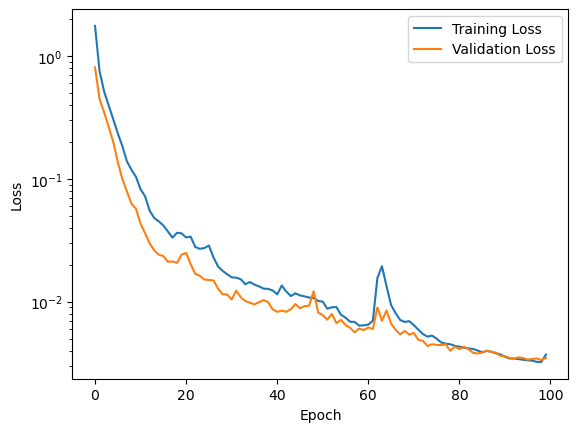

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()


In [18]:
snapshot_plot = snapshots_test.T.reshape(num_samples,time_steps,n*n)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 621ms/step
Sample 1
True Modes: [-0.00635285  0.00700021  0.00528016 -0.00369826 -0.00969974 -0.00052182
  0.00215029  0.00459098 -0.00020232  0.00524279  0.00031329]
Predicted Modes: [-0.00585546  0.00698797  0.00542643 -0.00415112 -0.00966812 -0.00084836
  0.00232211  0.00464842 -0.00065603  0.00502423  0.0004712 ]


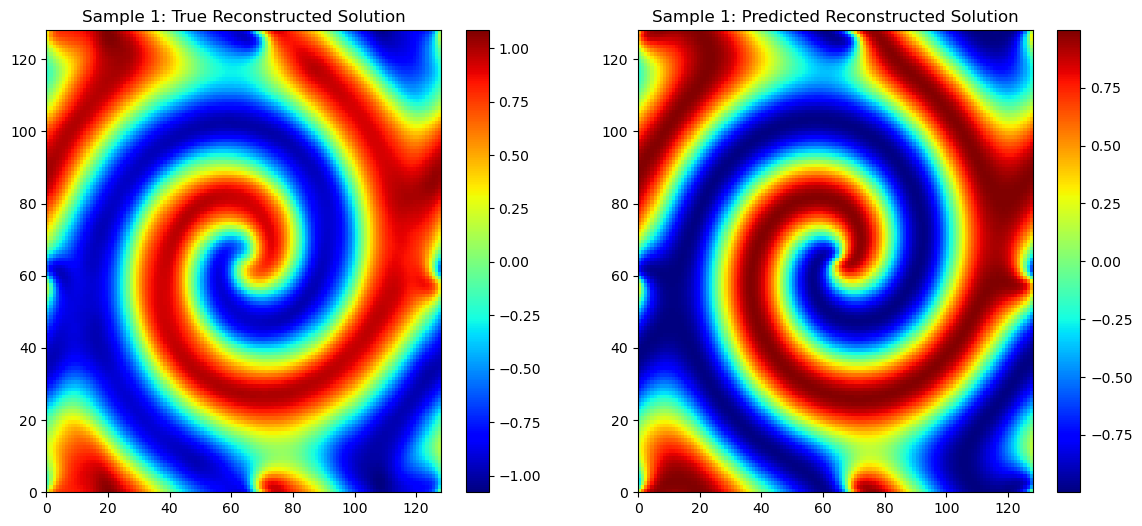

Sample 2
True Modes: [-0.00636776 -0.00307396  0.00946359  0.00103041 -0.01194684  0.02003116
  0.00660943 -0.00565059  0.00330687 -0.00141277  0.0028921 ]
Predicted Modes: [-0.00639586 -0.00321986  0.00979118  0.00081896 -0.01226915  0.01940005
  0.00657535 -0.00598728  0.00344213 -0.00140998  0.00313411]


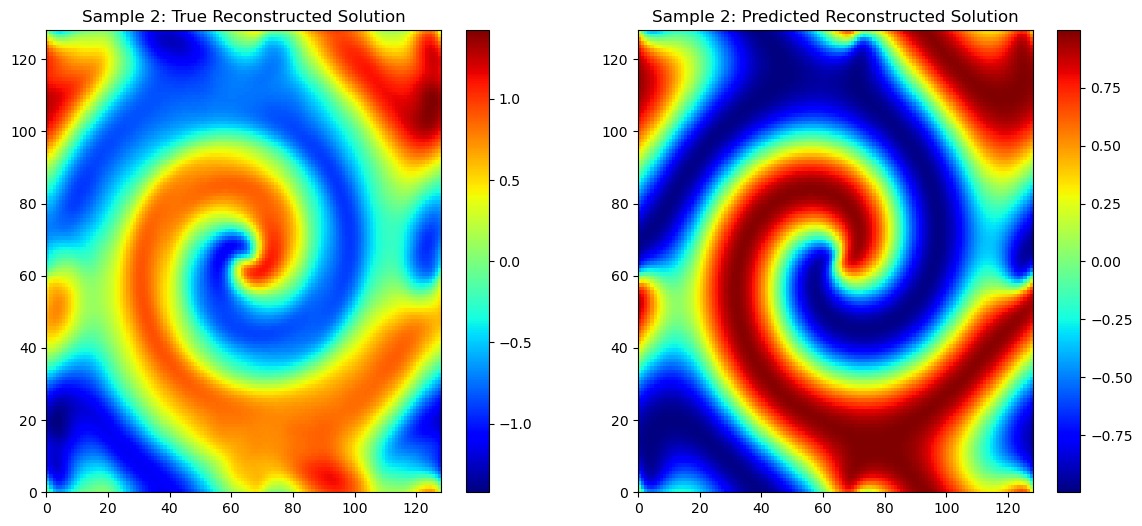

Sample 3
True Modes: [-0.00433973  0.001921   -0.00073964 -0.01570899  0.01499562  0.0069943
  0.0183362   0.01061111  0.00201009  0.00204187  0.01596669]
Predicted Modes: [-0.00306977  0.00271054 -0.00163919 -0.01555208  0.01381489  0.00725564
  0.01736697  0.01034756  0.00252001  0.00254028  0.01457404]


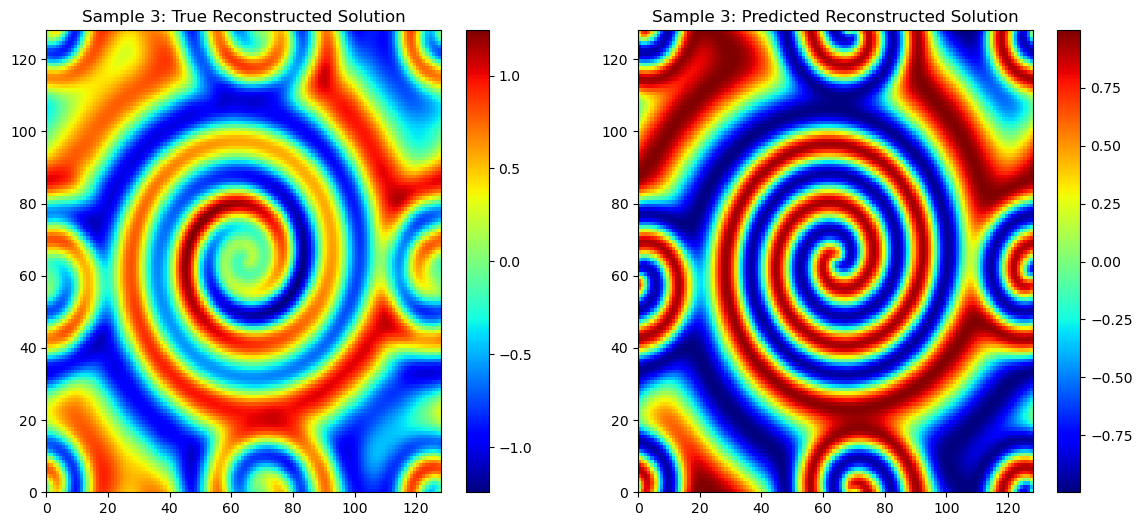

Sample 4
True Modes: [ 0.00088522 -0.00160883  0.00050313  0.01249666 -0.02294762 -0.00348083
 -0.02717785 -0.00733526 -0.00987863 -0.01314663 -0.00992142]
Predicted Modes: [ 0.00026766 -0.00120414  0.00014185  0.01245564 -0.02315983 -0.00345457
 -0.02719408 -0.00786393 -0.01157166 -0.01034082 -0.00434464]


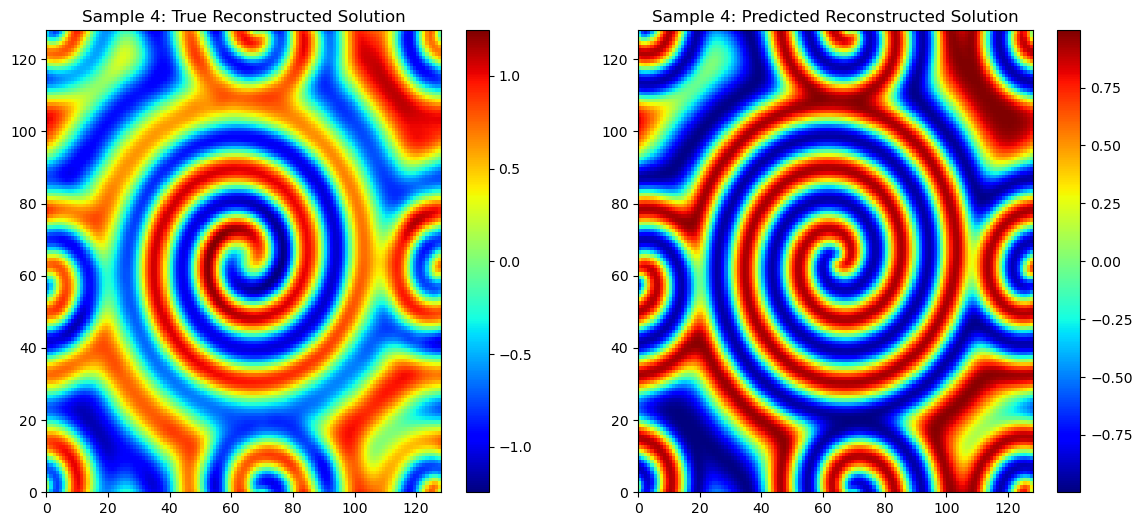

Sample 5
True Modes: [-0.00600645  0.00654502  0.00273477 -0.00300475 -0.01355964  0.00128871
  0.00771133  0.00321562  0.00530741  0.00418731 -0.00640363]
Predicted Modes: [-0.00585437  0.00628919  0.00293625 -0.00292403 -0.01355327  0.00106225
  0.0073208   0.00358256  0.0050809   0.00527273 -0.00648863]


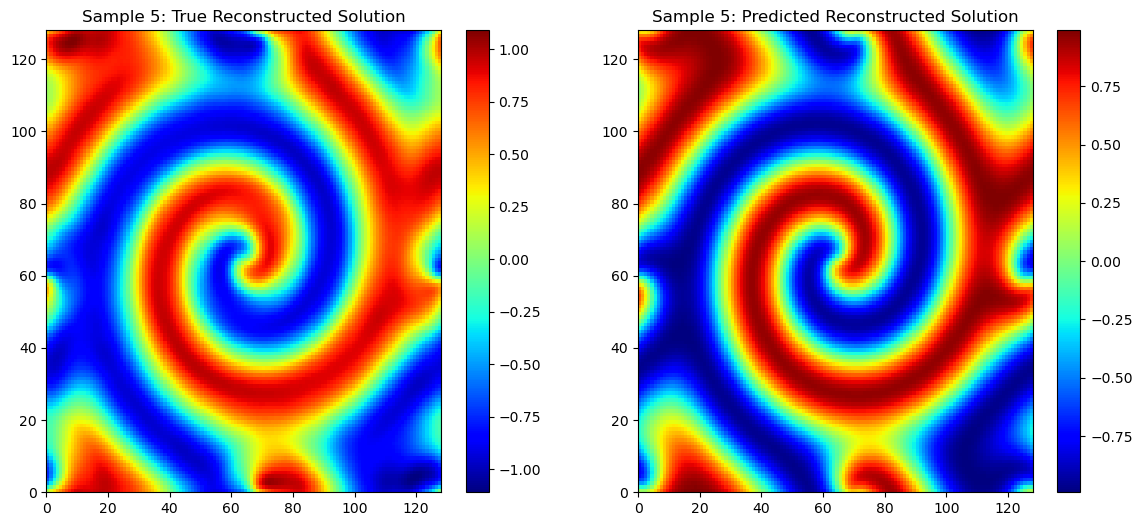

In [19]:
# Evaluate the model
y_pred_scaled = combined_model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled.reshape(-1, 11)).reshape(y_test.shape)
# Visualize results for a few test samples with reconstructed solutions
for i in range(5):  # Compare 5 samples
    true_modes = y_test[i, -1]  # Last time step's true modes
    pred_modes = y_pred[i, -1]  # Last time step's predicted modes

    # Reconstruct solutions using POD modes
    true_solution = POD_modes[:, :11] @ (Sigma[:11] * pred_modes)
    pred_solution = snapshot_plot[i,-1,:]

    # Reshape solutions to grid size
    n = int(np.sqrt(POD_modes.shape[0]))
    true_solution_grid = true_solution.reshape((n, n))
    pred_solution_grid = pred_solution.reshape((n, n))

    # Print true and predicted modes
    print(f"Sample {i + 1}")
    print(f"True Modes: {true_modes}")
    print(f"Predicted Modes: {pred_modes}")

    # Grid visualization for true and predicted solutions
    plt.figure(figsize=(14, 6))

    # True solution
    plt.subplot(1, 2, 1)
    plt.pcolormesh(true_solution_grid, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"Sample {i + 1}: True Reconstructed Solution")

    # Predicted solution
    plt.subplot(1, 2, 2)
    plt.pcolormesh(pred_solution_grid, shading='auto', cmap='jet')
    plt.colorbar()
    plt.title(f"Sample {i + 1}: Predicted Reconstructed Solution")

    plt.show()